In [1]:
import os
import json
import numpy as np
from tqdm import trange

Разметка и агрегация mean opinion score (MOS)

In [7]:
path = '/Users/sterling-gg/Downloads/mos_assignments_synth.tsv'
data = open(path).read().split('\n')
header = data[0].split('\t')
data = [d.split('\t') for d in data[1:]]
print(header)
print('num rows: {}'.format(len(data)))

['INPUT:text', 'INPUT:audio', 'OUTPUT:result', 'GOLDEN:result', 'HINT:text', 'HINT:default_language', 'ASSIGNMENT:link', 'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status', 'ASSIGNMENT:started']
num rows: 2080


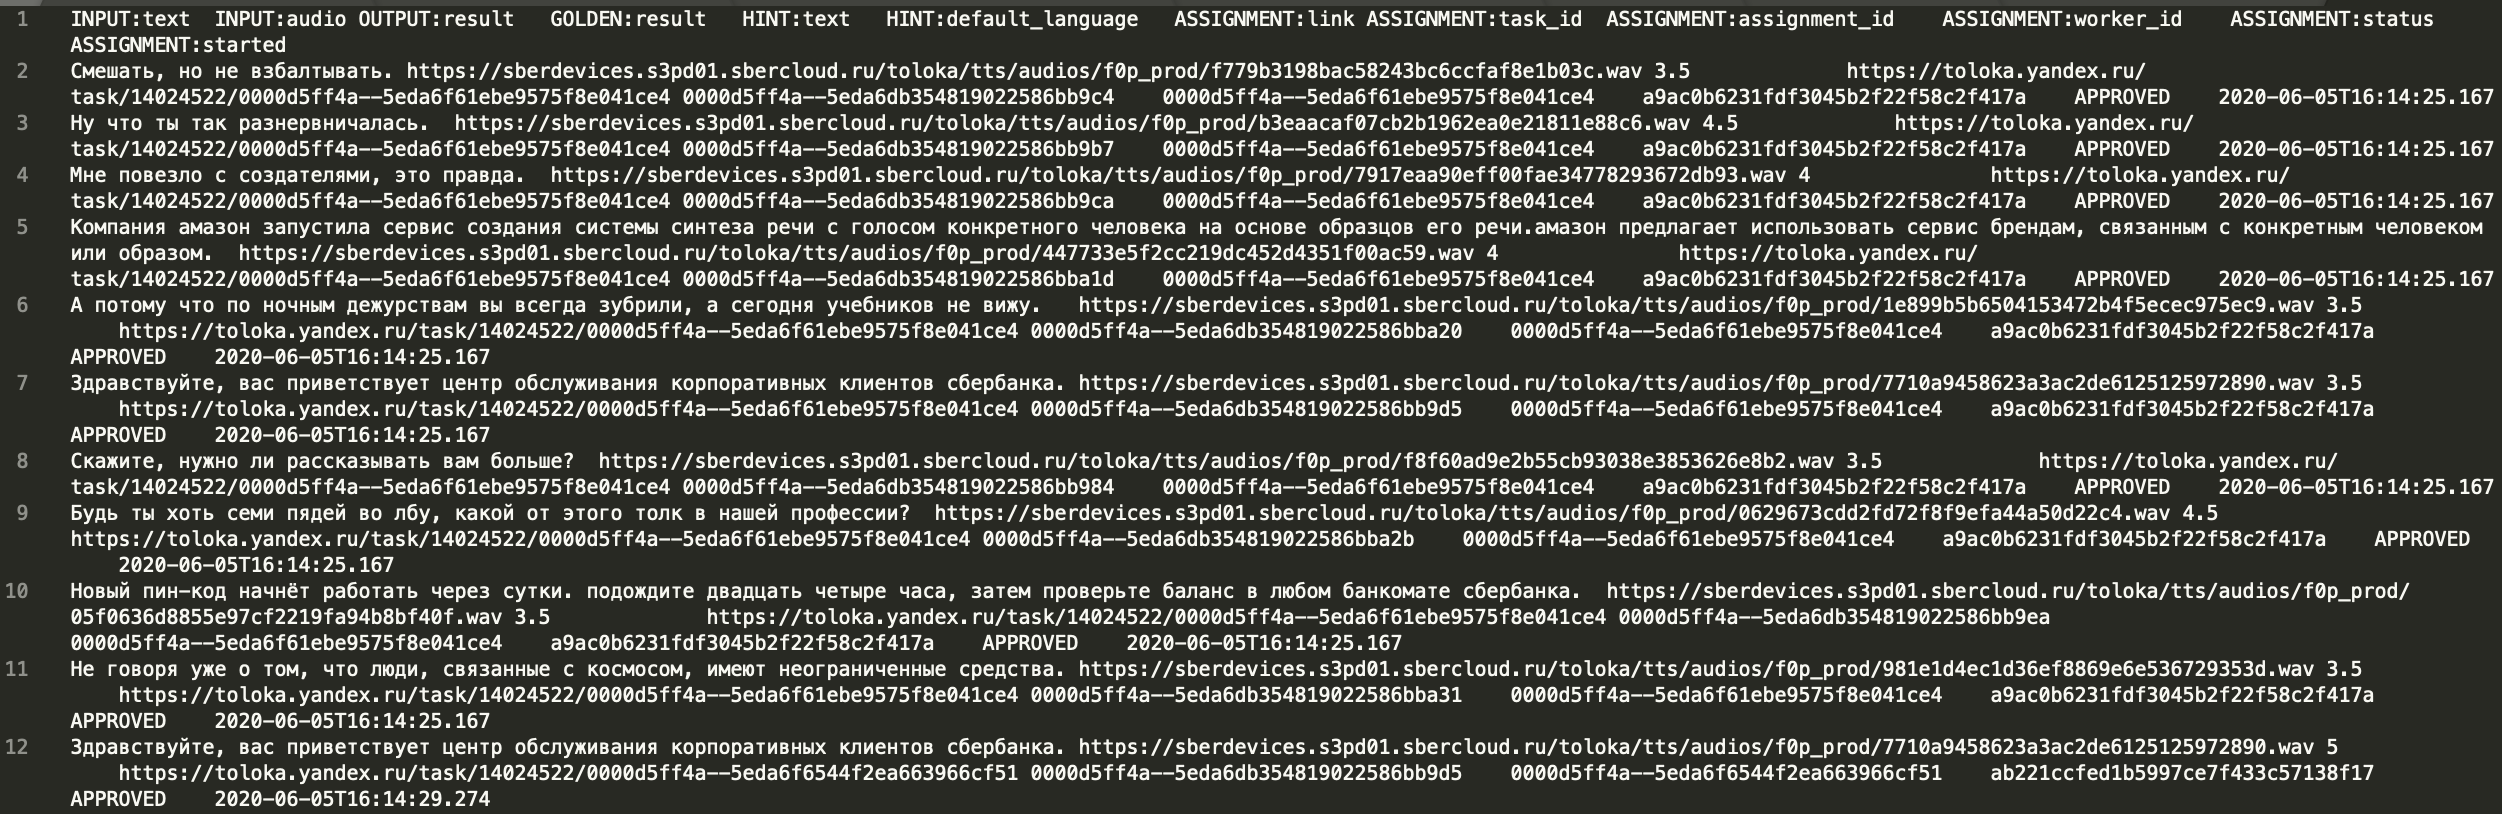

In [8]:
votes = np.array([d[2] for d in data[1:] if d[2].isdigit()], dtype=float)
print(votes)
print(np.mean(votes), np.std(votes))

[4. 4. 5. ... 4. 4. 5.]
4.325037707390648 0.8574527976730135


In [9]:
def aggregate_by_assessor(data):
    result = {}
    for line in data:
        assessor = line[9]
        vote = line[2]
        if vote.isdigit():
            if not assessor in result:
                result[assessor] = []
            result[assessor].append(float(vote))
    return result
    
by_assessor = aggregate_by_assessor(data)
mean_votes = [np.mean(b) for b in by_assessor.values()]
print('MOS={}, std={}'.format(np.mean(mean_votes), np.std(mean_votes)))


MOS=4.240668701993705, std=0.4848798087727183


In [10]:
print('Mean number of audios seen by assessor:', np.mean([len(b) for b in by_assessor.values()]))
print('Total number of audios:', len(np.unique([d[1] for d in data])))

Mean number of audios seen by assessor: 16.37037037037037
Total number of audios: 200


In [12]:
# bootstrap

audios = np.unique([d[1] for d in data])

results = []

for i in trange(100):
    subset_audios = np.random.choice(audios, size=100)
    subset_data = [d for d in data if d[1] in subset_audios]
    
    by_assessor = aggregate_by_assessor(subset_data)
    mean_votes = [np.mean(b) for b in by_assessor.values()]
    # print('MOS={}, std={}'.format(np.mean(mean_votes), np.std(mean_votes)))
    
    results.append(np.mean(mean_votes))
print('Bootstrap MOS={}, std={}'.format(np.mean(results), np.std(results)))

    

100%|██████████| 100/100 [00:02<00:00, 39.25it/s]

Bootstrap MOS=4.236785169600204, std=0.05731464539401242


Разметка и агрегация SBS

In [13]:
path = '/Users/sterling-gg/Downloads/sbs_assignments.tsv'
assignments = open(path).read().split('\n')
header = assignments[0]
data = [d.split('\t') for d in assignments[1:]]
print(header)
print('num rows: {}'.format(len(data)))

INPUT:text	INPUT:record_A	INPUT:record_B	OUTPUT:result	GOLDEN:result	HINT:text	HINT:default_language	ASSIGNMENT:link	ASSIGNMENT:task_id	ASSIGNMENT:assignment_id	ASSIGNMENT:worker_id	ASSIGNMENT:status	ASSIGNMENT:started
num rows: 3266


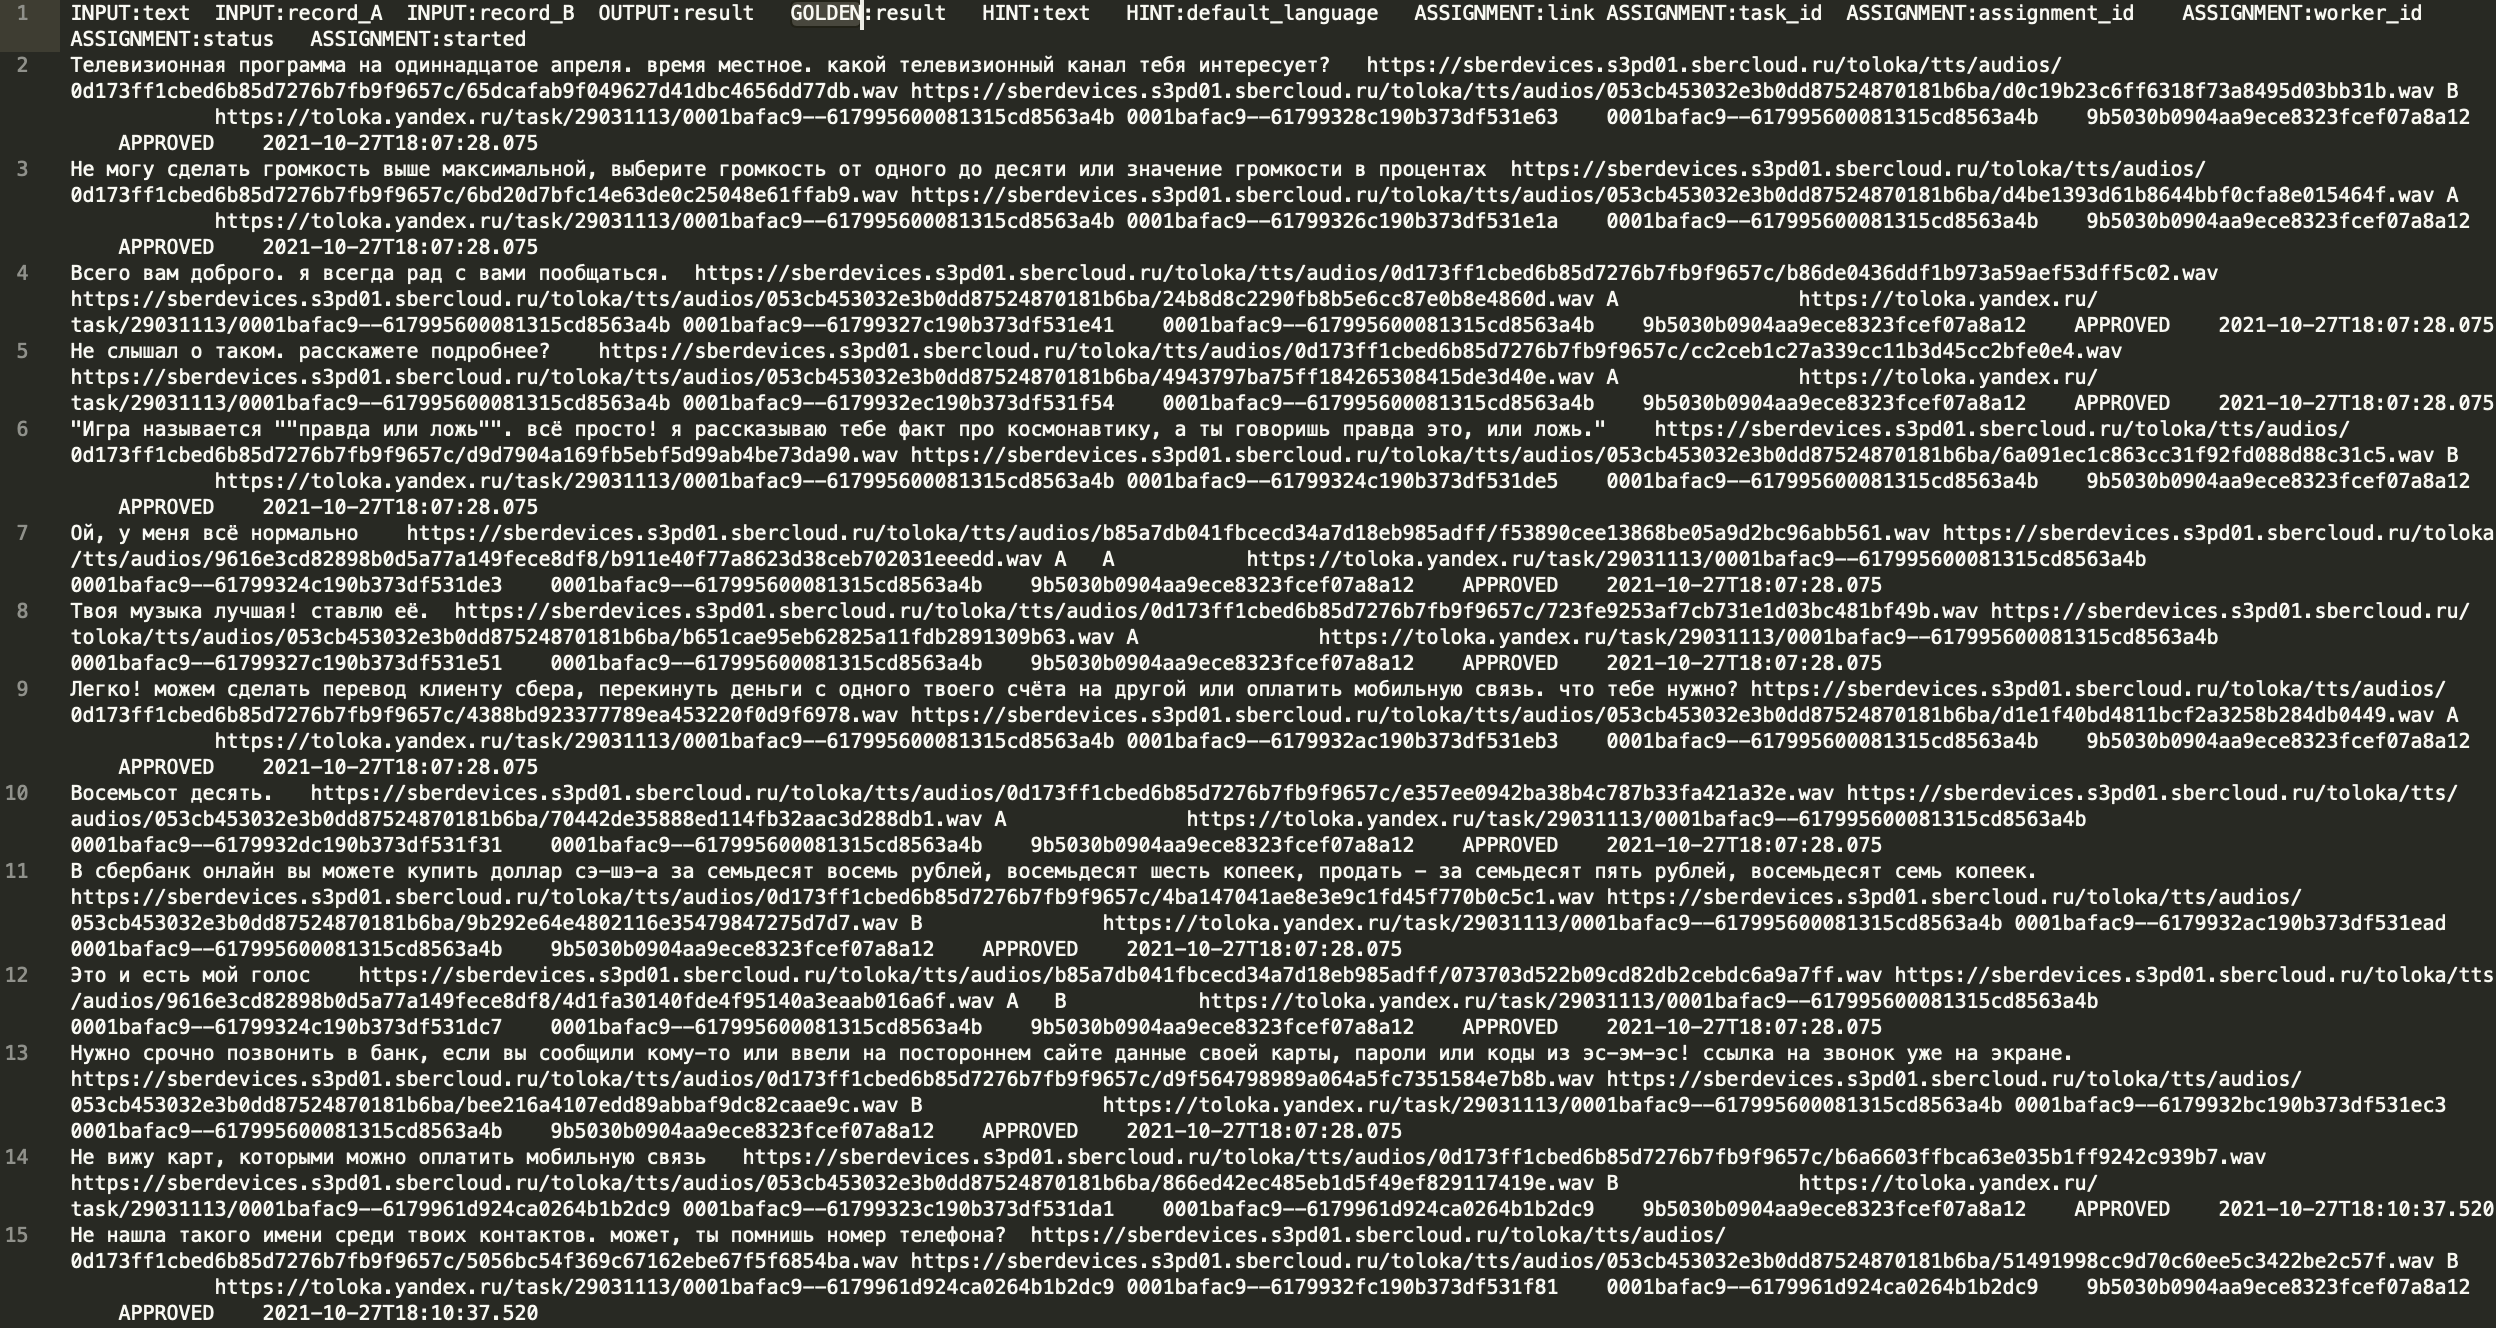

In [14]:
def aggregate_by_text(data):
    result = {}
    for line in data:
        text = line[0]
        vote = line[3]
        if vote in ['A', 'B'] and line[4] == '':  # do not forget about honeypots
            if not text in result:
                result[text] = []
            result[text].append(vote)
    return result

by_text = aggregate_by_text(data)
print('mean votes for model A:', np.mean([np.mean([vi == 'A' for vi in v]) for v in by_text.values()]))
print('mean votes for model B:', np.mean([np.mean([vi == 'B' for vi in v]) for v in by_text.values()]))

mean votes for model A: 0.37135518684948343
mean votes for model B: 0.6286448131505167


In [ ]:
Проверяем статзначимость гипотезы, что модели A и B одинаковые

In [16]:
na = len([d for d in data if d[3] == 'A'])
nb = len([d for d in data if d[3] == 'B'])
n = na + nb
print(na, nb, n)

p_hypothesis = 0.4

Z = (na / n - p_hypothesis) / np.sqrt(p_hypothesis * (1 - p_hypothesis) / n)

print('Z-statistic value:', Z)
print('Probability of H0 is true:', np.exp(-Z**2 / 2) / np.sqrt(2 * np.pi))

1234 1947 3181
Z-statistic value: -1.3897726763017884
Probability of H0 is true: 0.15187877957564586
